### Optimal control of phenomenological models, e.g. the model model
This notebook shows how to compute the optimal control (OC) signal for the model model for a simple example task. For the Hopf-model the OC can be computed completely analogously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

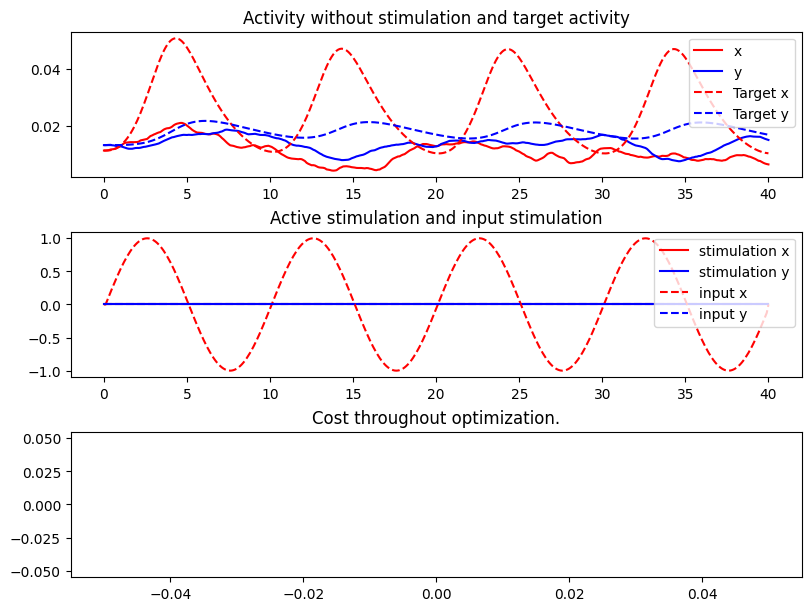

In [2]:
# We import the model
model = WCModel()

# Set noise strength to zero to define target state
model.params.sigma_ou = 0.

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 40.
amplitude = 1.
period = duration / 4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.011225367461896877
y_init = 0.013126741089502588
model.params["exc_init"] = np.array([[x_init]])
model.params["inh_init"] = np.array([[y_init]])

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
# Change sigma_ou_parameter to adjust the noise strength
model.params['sigma_ou'] = 0.01
model.params['tau_ou'] = 1.
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

The target is a periodic oscillation of x and y variable (computed in deterministic, noise-free system).

The noisy, undistrubed system fluctuates around zero.

For the optimization, you can now set several new parameters:
- M: the number of noise realizations that the algorithm averages over. Default=1
- M_validation: the number of noise realization the final cost is computed from. Default=1000
- validate_per_step: If True, the cost for each step is computed averaging over M_validation instead of M realizations, this takes much longer. Default=False
- method: determines, how the noise averages are computed. Results may vary for different methods depending on the specific task. Choose from ['3']. Default='3'

Please note:
- higher number of iterations does not promise better results for computations in noisy systems. The cost will level off at some iteration number, and start increasing again afterwards. Make sure not to perform too many iterations.
- M, M_validation should increase with sigma_ou model parameter
- validate_per_step does not impact the control result

Let's first optimize with the following parameters: M=20, iterations=100

Compute control for a noisy system
Mean cost in iteration 0: 0.00881680097910236
Mean cost in iteration 10: 0.008648039398833138
Mean cost in iteration 20: 0.008695985092026029
Mean cost in iteration 30: 0.008604405795189998
Mean cost in iteration 40: 0.00868499122431353
Mean cost in iteration 50: 0.00865384559006611
Mean cost in iteration 60: 0.008751760160160932
Mean cost in iteration 70: 0.00867614172494621
Mean cost in iteration 80: 0.008706308135922712
Mean cost in iteration 90: 0.00853634777066831
Mean cost in iteration 100: 0.008586161214584945
Minimal cost found at iteration 2
Final cost validated with 500 noise realizations : 0.008634815014559273


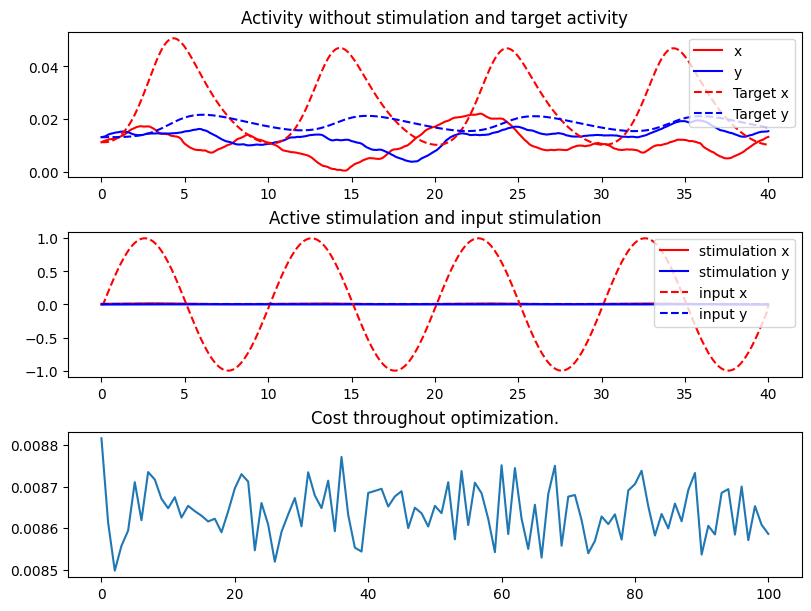

In [3]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, target, print_array=np.arange(0,101,10),
        M=20, M_validation=500, validate_per_step=True)

# We run 100 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)


Let's do the same thing with different parameters: M=100, iterations=30

Compute control for a noisy system
Mean cost in iteration 0: 0.00884106549015272
Mean cost in iteration 5: 0.008829585755423893
Mean cost in iteration 10: 0.008804984816750627
Mean cost in iteration 15: 0.00883267455503791
Mean cost in iteration 20: 0.008778218135625113
Mean cost in iteration 25: 0.008794617127268806
Mean cost in iteration 30: 0.008869532796248822
Minimal cost found at iteration 24
Final cost validated with 500 noise realizations : 0.00886175054169


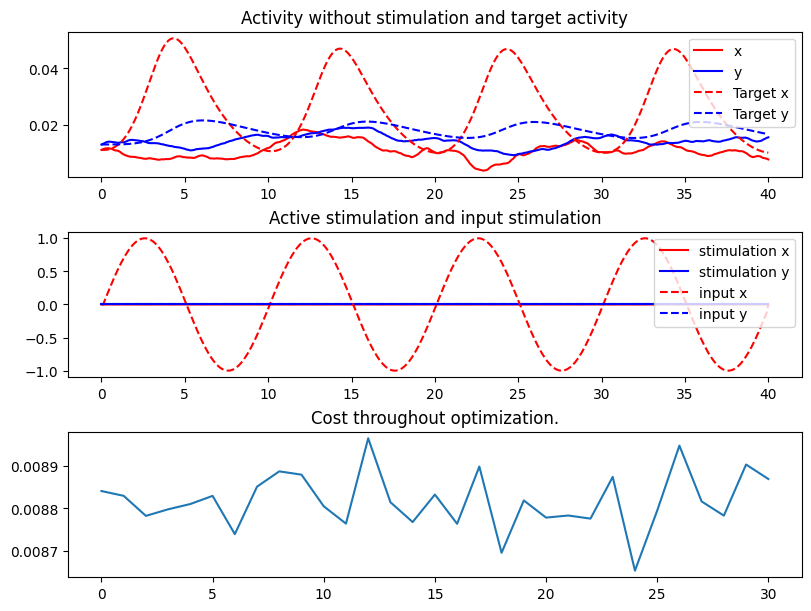

In [4]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, target,print_array=np.arange(0,31,5),
        M=100, M_validation=500, validate_per_step=True)

# We run 30 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(30)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of model oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

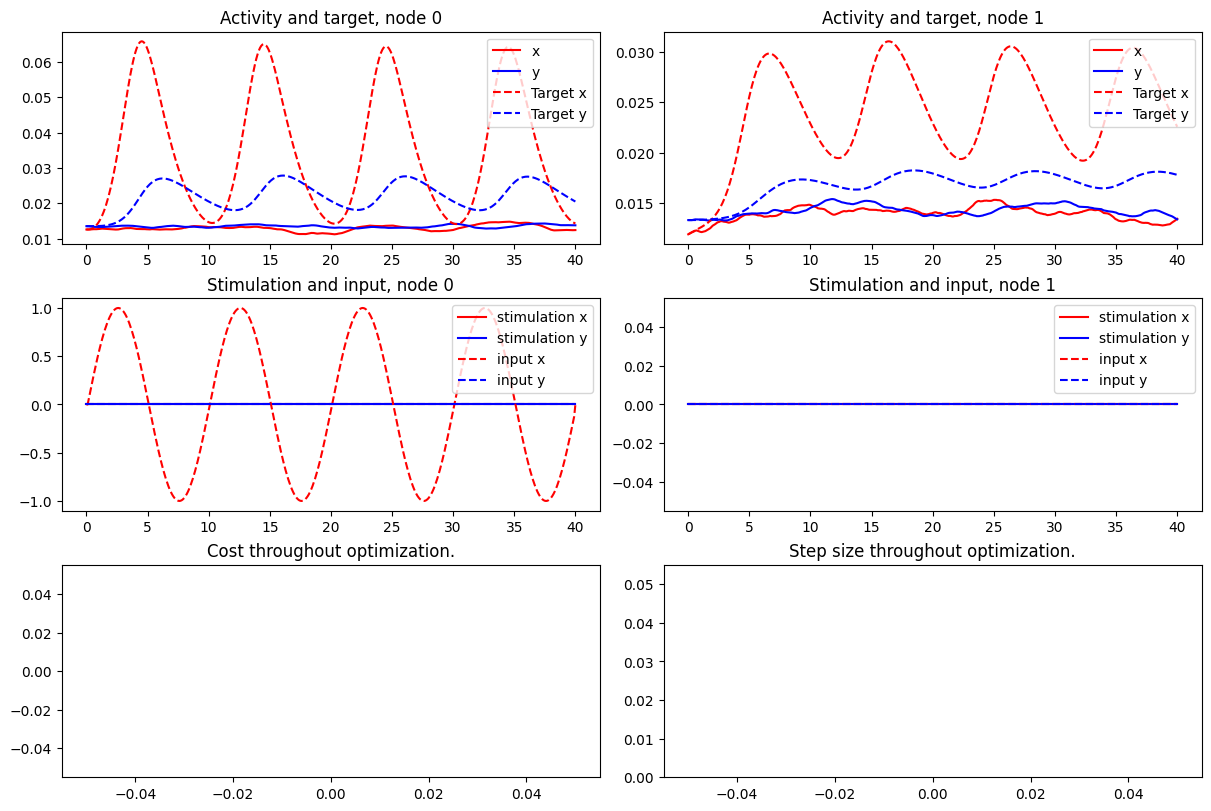

In [5]:
cmat = np.array( [[0., 0.5], [1.0, 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = WCModel(Cmat=cmat, Dmat=dmat)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

model.params.K_gl = 10.

# Set noise strength to zero to define target state
model.params['sigma_ou'] = 0.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well
model.params["exc_init"] = np.vstack( [0.01255381969006173, 0.01190300495001282] )
model.params["inh_init"] = np.vstack( [0.013492631513639169, 0.013312224583806076] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params['sigma_ou'] = 0.002
model.params['tau_ou'] = 1.
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Let's optimize with the following parameters: M=20, iterations=100

Compute control for a noisy system
Mean cost in iteration 0: 0.002382672629174073
Mean cost in iteration 10: 0.0003912166377193999
Mean cost in iteration 20: 0.000250331273756896
Mean cost in iteration 30: 0.00022557713072960113
Mean cost in iteration 40: 0.00023001204725883165
Mean cost in iteration 50: 0.00022942519648088322
Mean cost in iteration 60: 0.00023245606827404302
Mean cost in iteration 70: 0.00022912833161274997
Mean cost in iteration 80: 0.00022938780218675824
Mean cost in iteration 90: 0.0002296589989604559
Mean cost in iteration 100: 0.0002279414548545365
Minimal cost found at iteration 48
Final cost validated with 500 noise realizations : 0.00023006065872936758


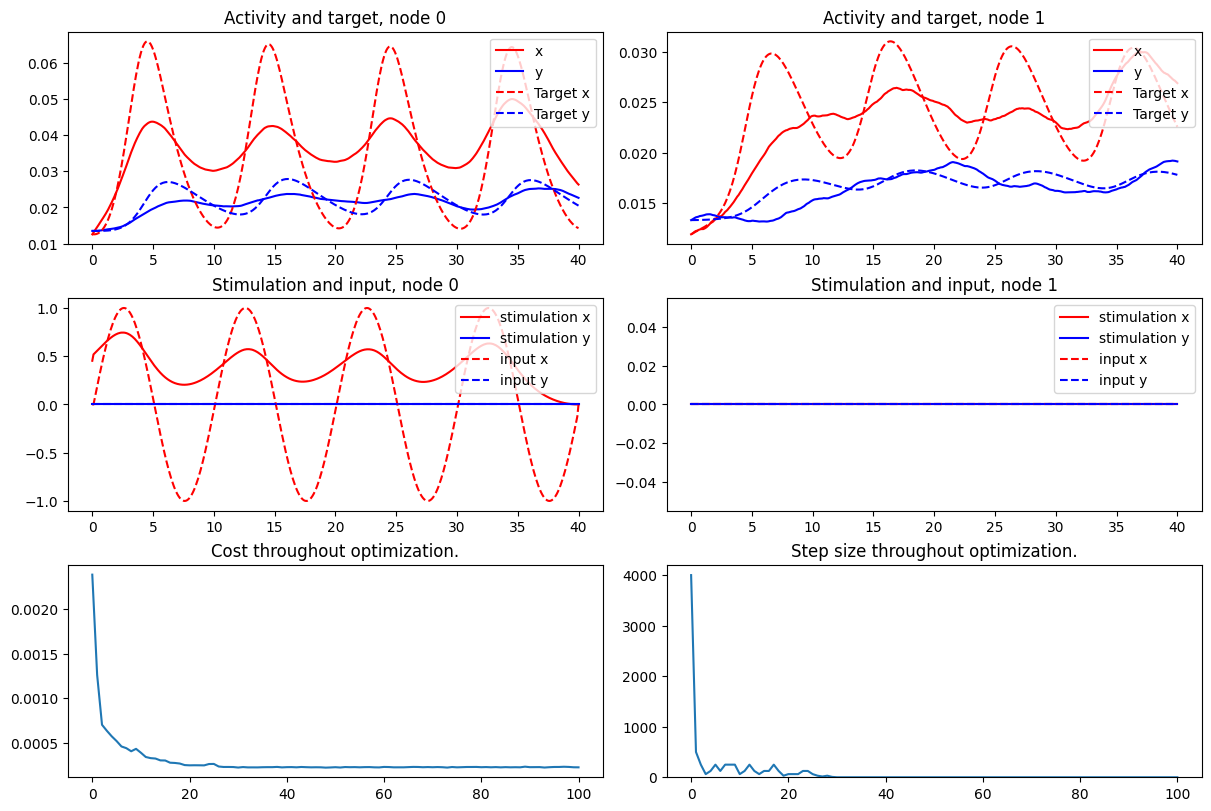

In [6]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[1,0] = 1. # only measure in x-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model,
                                target,
                                print_array=np.arange(0,101,10),
                                control_matrix=control_mat,
                                cost_matrix=cost_mat,
                                M=20,
                                M_validation=500,
                                validate_per_step=True)

# increase start step so that the algorithm converges faster
model_controlled.step = 2000
# We run 100 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Let's do the same thing with different parameters: M=100, iterations=30

Compute control for a noisy system
Mean cost in iteration 0: 0.00239306840233193
Mean cost in iteration 5: 0.0005212770727731364
Mean cost in iteration 10: 0.0003423279612871228
Mean cost in iteration 15: 0.0002752475367548875
Mean cost in iteration 20: 0.00025604666123206135
Mean cost in iteration 25: 0.00025556858899728206
Mean cost in iteration 30: 0.00025671908013372754
Minimal cost found at iteration 18
Final cost validated with 500 noise realizations : 0.0002551796996908546


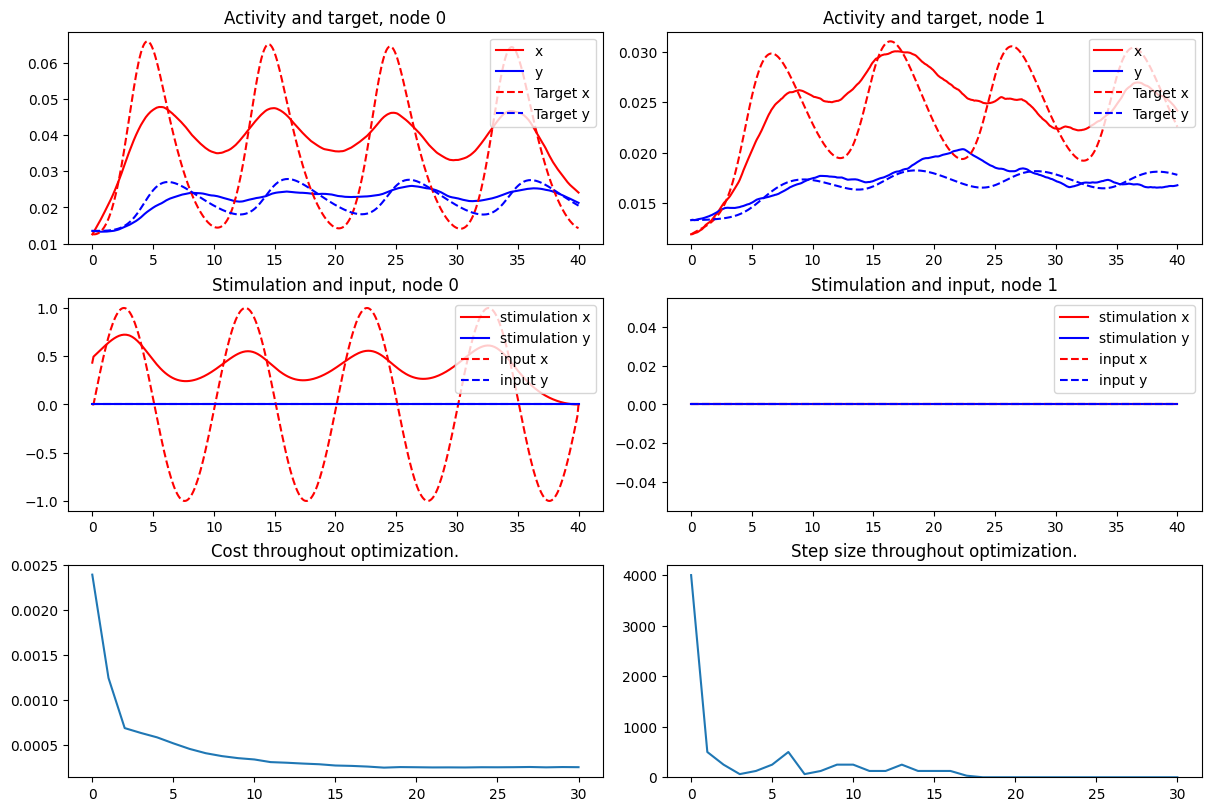

In [7]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model,
                                target,
                                print_array=np.arange(0,31,5),
                                control_matrix=control_mat,
                                cost_matrix=cost_mat,
                                M=100,
                                M_validation=500,
                                validate_per_step=True)

# increase start step so that the algorithm converges faster
model_controlled.step = 2000
# We run 30 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(30)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)